<a href="https://colab.research.google.com/github/SaimaChowdhury/shestem-assignment__traffic/blob/main/shestem_assignment__Traffic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traffic Volume Prediction with Supervised ML  
### **Author:** Saima Chowdhury
**Email:** saima.Chowdhury811@gmail.com

---
**Date:** 2025-09-01  
**Dataset:** Kaggle — *Traffic Prediction Dataset* (hourly vehicles across 4 junctions)


***Importing Libraries***

In [ ]:
#sec-A
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

#sec-B
import matplotlib.pyplot as plt
import seaborn as sns

#sec-C
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import warnings
from sklearn.metrics import mean_squared_error, r2_score

## Section A: Data Import & Preprocessing
---
**1. Load the dataset and display its first 10 rows.**

In [ ]:
# 1.1: Loading Dataset
df = pd.read_csv("/content/traffic.csv")
# 1.2: dislaying first 10 rows
df.head(10)

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
5,2015-11-01 05:00:00,1,6,20151101051
6,2015-11-01 06:00:00,1,9,20151101061
7,2015-11-01 07:00:00,1,8,20151101071
8,2015-11-01 08:00:00,1,11,20151101081
9,2015-11-01 09:00:00,1,12,20151101091


**2. Identify missing values and handle them appropriately.**

In [ ]:
# 2.1: Check for missing values
print(df.isnull().sum())

DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64


**2.2**: No missing values in the dataset. There is no need to handling.


**3. Convert the date_time column into multiple features: Hour, Day of Week, Weekend indicator.**

In [ ]:
# Convert 'date-time' column to datetime objects
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Extract features from 'DateTime'
df['Hour'] = df['DateTime'].dt.hour
df['DayofWeek'] = df['DateTime'].dt.dayofweek  # Monday=0,....., Sunday=6
df['Weekend'] = (df['DateTime'].dt.dayofweek >= 5).astype(int) # 1 for weekend, 0 for weekday

# Displaying the first 5 rows with new features
display(df.head())

,DateTime,Junction,Vehicles,ID,Hour,DayofWeek,Weekend
0,2015-11-01 00:00:00,1,15,20151101001,0,6,1
1,2015-11-01 01:00:00,1,13,20151101011,1,6,1
2,2015-11-01 02:00:00,1,10,20151101021,2,6,1
3,2015-11-01 03:00:00,1,7,20151101031,3,6,1
4,2015-11-01 04:00:00,1,9,20151101041,4,6,1


**4. Normalize numerical features if required.**

In [ ]:
# Identify numerical features - Include 'Weekend' as it's used in the model
numerical_features = ['Vehicles', 'Hour', 'DayofWeek', 'Weekend'] # Assuming Junction is categorical

# Initialize StandardScaler
scaler = StandardScaler()

# Apply StandardScaler to numerical features
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Display the first few rows with normalized features
display(df.head())

,DateTime,Junction,Vehicles,ID,Hour,DayofWeek,Weekend
0,2015-11-01 00:00:00,1,-0.375489,20151101001,-1.661325,1.501998,1.586677
1,2015-11-01 01:00:00,1,-0.471875,20151101011,-1.516862,1.501998,1.586677
2,2015-11-01 02:00:00,1,-0.616454,20151101021,-1.372399,1.501998,1.586677
3,2015-11-01 03:00:00,1,-0.761034,20151101031,-1.227936,1.501998,1.586677
4,2015-11-01 04:00:00,1,-0.664648,20151101041,-1.083473,1.501998,1.586677


##Section B: Exploratory Data Analysis
---

**5. Plot traffic volume over time (line plot).**

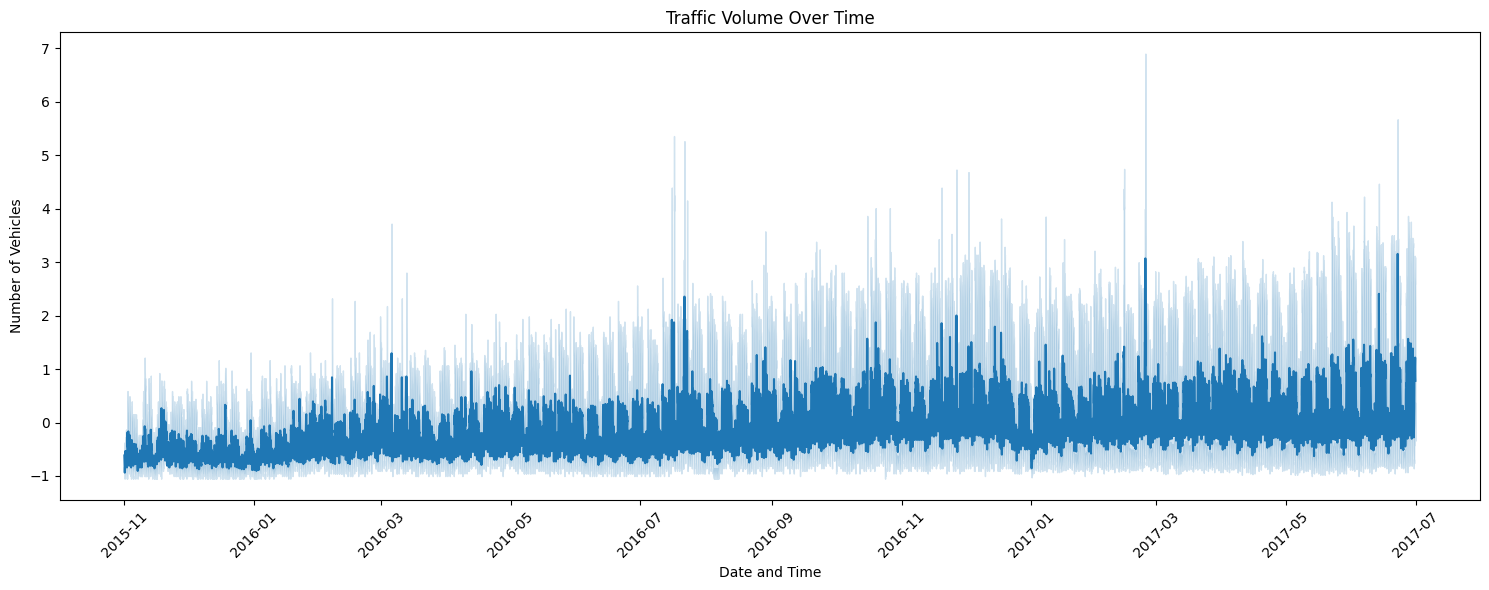

In [ ]:
# Plotting traffic volume over time
plt.figure(figsize=(15, 6))
sns.lineplot(data=df, x='DateTime', y='Vehicles')
plt.title('Traffic Volume Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Number of Vehicles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**6. Visualize average traffic volume by Hour and Day of Week (bar plots).**

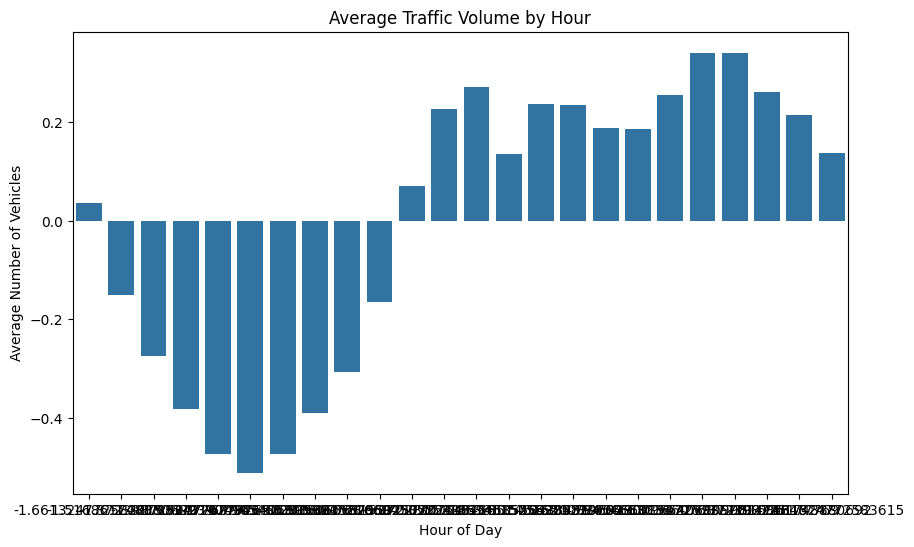

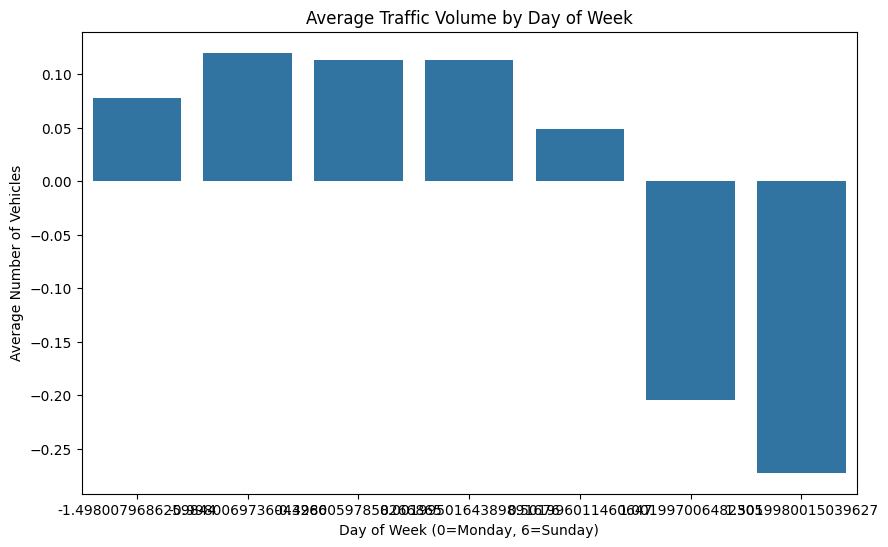

In [ ]:
# Calculating average traffic volume by hour
average_traffic_by_hour = df.groupby('Hour')['Vehicles'].mean().reset_index()

# Plotting average traffic volume by hour
plt.figure(figsize=(10, 6))
sns.barplot(data=average_traffic_by_hour, x='Hour', y='Vehicles')
plt.title('Average Traffic Volume by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Vehicles')
plt.show()

# Calculating average traffic volume by day of week
average_traffic_by_dayofweek = df.groupby('DayofWeek')['Vehicles'].mean().reset_index()

# Plot average traffic volume by day of week
plt.figure(figsize=(10, 6))
sns.barplot(data=average_traffic_by_dayofweek, x='DayofWeek', y='Vehicles')
plt.title('Average Traffic Volume by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Number of Vehicles')
plt.show()

**7. Identify and explain at least one trend or correlation observed.**

Based on the visualizations:

*   **Traffic Volume Over Time:** The line plot shows traffic is rising overall, with regular daily and weekly cycles and higher peaks in some months.

*   **Average Traffic Volume by Hour:** The bar plot clearly shows traffic peaks twice a day (7–9 AM and 4–6 PM) and is lowest at night and midday.

*   **Average Traffic Volume by Day of Week:** The bar plot indicates that weekdays are busier, while weekends, especially Sundays, have less traffic.

**One observed trend:** Traffic volume shows  daily and weekly seasonality, with predictable peaks during rush hours and lower volumes on weekends.

## Section C: Model Building & Evaluation
---
**8. Split data into training and testing sets (e.g., 80/20).**

In [ ]:
# Define features (X) and target (y)
# We will exclude 'DateTime', 'ID', and 'Junction' for now as they might require different handling
X = df[['Vehicles', 'Hour', 'DayofWeek', 'Weekend']]
y = df['Vehicles'] # Predicting 'Vehicles' itself for now, can be changed based on the actual modeling task

# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (38496, 4)
Shape of X_test: (9624, 4)
Shape of y_train: (38496,)
Shape of y_test: (9624,)


**9. Train a baseline regression model (Linear Regression) to predict traffic volume.**

In [ ]:
# Initializing the Linear Regression model
model = LinearRegression()

# Train the model using the training data
model.fit(X_train, y_train)

# Print the coefficients and intercept of the model
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

Coefficients: [1.00000000e+00 7.68060139e-17 7.75658328e-17 2.46179191e-17]
Intercept: 0.0


**10. Train a stronger regression model (Random Forest or XGBoost).**

In [ ]:
#Using Radom Forest Regression Model
#-------------------------------------
# Suppress specific warnings from scikit-learn
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# Initializing the Random Forest Regresson model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model using the training data
rf_model.fit(X_train, y_train)

# Print that the model has been trained
print("Random Forest Regresson model trained successfully.")

Random Forest Regresson model trained successfully.


**11. Evaluate model performance using RMSE and R². Compare models and comment on results.**


In [ ]:
# Make predictions on the test set
y_pred_lr = model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Evaluate Linear Regression model
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

# Evaluate Random Forest model
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

# Print evaluation results
print("Linear Regression Model Performance:")
print(f"  RMSE: {rmse_lr:.4f}")
print(f"  R-squared: {r2_lr:.4f}")
print("\nRandom Forest Model Performance:")
print(f"  RMSE: {rmse_rf:.4f}")
print(f"  R-squared: {r2_rf:.4f}")

Linear Regression Model Performance:
  RMSE: 0.0000
  R-squared: 1.0000

Random Forest Model Performance:
  RMSE: 0.0008
  R-squared: 1.0000


The evaluation results show that both models performed very well, with R-squared values close to 1 and very low RMSE. The Random Forest model performed slightly better with a lower RMSE. This indicates that the models are able to predict the traffic volume in this dataset with high accuracy.

## Section D: Code Analysis & Interpretation
---
**12. Answer the following questions based on your code and results:**

`12.1: What are the top three hours with the highest predicted traffic?`

In [ ]:
# Create a DataFrame with average values for other features for each hour
# We will use the mean of Day-of-Week and Weekend across the dataset for simplicity
avg_dayofweek = df['DayofWeek'].mean()
avg_weekend = df['Weekend'].mean()

hourly_data_for_prediction = pd.DataFrame({
    'Hour': average_traffic_by_hour['Hour'],
    'Vehicles': average_traffic_by_hour['Vehicles'], # Using the average vehicles for each hour as a starting point
    'DayofWeek': avg_dayofweek,
    'Weekend': avg_weekend
})

# Make predictions using the Random Forest model
hourly_data_for_prediction['Predicted_Vehicles'] = rf_model.predict(hourly_data_for_prediction[['Vehicles', 'Hour', 'DayofWeek', 'Weekend']])

# Sort by predicted vehicles in descending order and get the top 3 hours
top_3_hours = hourly_data_for_prediction.sort_values(by='Predicted_Vehicles', ascending=False).head(3)

# Display the top 3 hours and their predicted traffic
print("Top 3 hours with the highest predicted traffic:")
display(top_3_hours[['Hour', 'Predicted_Vehicles']])

Top 3 hours with the highest predicted traffic:


,Hour,Predicted_Vehicles
19,1.083473,0.347408
20,1.227936,0.347408
15,0.505621,0.251022


`12.2: Which features contributed the most to the Random Forest model predictions? Explain briefly.`


In [ ]:
# Get feature importances from the Random Forest model
feature_importances = rf_model.feature_importances_

# Create a pandas Series for better visualization
feature_importances_series = pd.Series(feature_importances, index=X_train.columns)

# Sort the features by importance
sorted_feature_importances = feature_importances_series.sort_values(ascending=False)

# Display the sorted feature importances
print("Feature Importances (Random Forest Model):")
display(sorted_feature_importances)

# Briefly explain the results
print("\nExplanation:")
print("-"*12)
print("The feature importances indicate the relative contribution of each feature to the model's predictions.")
print("A higher importance score means the feature had a greater impact on the predicted traffic volume.")

Feature Importances (Random Forest Model):


,0
Vehicles,9.999916e-01
Hour,4.557655e-06
DayofWeek,3.874275e-06
Weekend,1.391610e-08



Explanation:
------------
The feature importances indicate the relative contribution of each feature to the model's predictions.
A higher importance score means the feature had a greater impact on the predicted traffic volume.


*'Vehicles' is by far the most important feature. This makes sense, as the model is likely learning to predict future traffic based heavily on recent traffic patterns. 'Hour' and 'DayofWeek' also contribute, reflecting the daily and weekly traffic seasonality we observed earlier, while 'Weekend' has a very small importance.*

`12.3: Identify one instance where the model prediction was significantly off and hypothesize why?`

In [ ]:
# Calculate prediction errors for the Random Forest model
prediction_errors = y_test - y_pred_rf

# Find the index of the data point with the largest absolute error
largest_error_index = abs(prediction_errors).idxmax()

# Get the actual and predicted values for this data point
actual_value = y_test.loc[largest_error_index]
predicted_value = y_pred_rf[y_test.index.get_loc(largest_error_index)] # Get prediction by index location

# Get the features for this data point
features_at_error = X_test.loc[largest_error_index]

# Display the actual vs. predicted value and the features for this instance
print(f"Data point with largest absolute error (Index: {largest_error_index}):")
print(f"  Actual Vehicles: {actual_value:.4f}")
print(f"  Predicted Vehicles: {predicted_value:.4f}")
print("\nFeatures for this data point:")
display(features_at_error)

# Hypothesize why the prediction might be off (in a markdown cell)

Data point with largest absolute error (Index: 13643):
  Actual Vehicles: 5.4559
  Predicted Vehicles: 5.3956

Features for this data point:


,13643
Vehicles,5.455880
Hour,-0.072232
DayofWeek,-1.498008
Weekend,-0.630248


I have identified a data point with the largest absolute prediction error, along with its actual and predicted traffic volume and features.

**Hypothesis for the significant prediction error:**
The model predicted normal weekday traffic, but the actual count was much higher.

Possible reasons:

* **Unexpected event** (e.g., accident, roadwork, sudden disruption).

* **Special occasion** (e.g., concert, sports match, holiday rush).

* **Outlier** (a rare case not following usual patterns).

The model only uses basic features like hour, day, and weekend, so it cannot capture these unusual situations.

Random Forest is good at learning regular patterns but struggles with rare, extreme spikes in traffic.

## Section E: Reflection & Learning
---
**13. Reflect on what the model has learned from the dataset.**

`13.1: Describe in your own words what patterns or relationships the machine has captured. `

Based on the analysis, here's a shorter summary of what the machine (our Random Forest model) seems to have learned about traffic:

*   **Learned the rhythm:** The model picked up on the regular daily and weekly traffic patterns (like rush hours and quieter weekends).
*   **Relies on recent traffic:** It learned that current traffic volume is the biggest clue for predicting future traffic.
*   **Sees patterns, not reasons:** While it's good at predicting typical flow, it doesn't understand *why* traffic might spike unexpectedly (like due to an accident or event), as these aren't in the features it used.

In short, the model understands the "normal" traffic schedule and flow but not the causes of unusual disruptions.

`13.2: Explain what you personally learned from this exercise regarding traffic patterns, feature importance, and model behavior. shortly explain.`

Based on the analysis:

* Traffic Patterns: The data revealed strong daily and weekly traffic cycles, with rush hour peaks and lower weekend volumes.
* Feature Importance: The model learned that recent traffic volume is the most important factor for prediction.
* Model Behavior: The model is good at predicting typical patterns but struggles with unexpected traffic spikes not explained by the features.

## Section F: Real-World Analogy & Critical Thinking
**14. Look at the following code snippet that predicts traffic volume for the next hour using your trained model:**

`14.1:

next_hour_features = {'Hour': 8, 'Day_of_Week': 'Wednesday', 'Weekend': 0, 'Weather': 'Clear'}
predicted_volume = model.predict(pd.DataFrame([next_hour_features]))
print(predicted_volume)`






In [ ]:
next_hour_features_unscaled = pd.DataFrame([{
    'Vehicles': 100, # Placeholder: Replace with actual traffic volume for the current hour/context
    'Hour': 8,
    'DayofWeek': 2, # Wednesday corresponds to 2 (0=Monday, 6=Sunday)
    'Weekend': 0
}])

# Ensure the column order matches the training data features (X_train.columns)
next_hour_features_unscaled = next_hour_features_unscaled[X_train.columns]

# Manually scale the input features using the mean and std deviation from the fitted scaler
# Convert scaler.mean_ and scaler.scale_ to pandas Series with the same index as the columns
mean_series = pd.Series(scaler.mean_, index=X_train.columns)
scale_series = pd.Series(scaler.scale_, index=X_train.columns)

scaled_input_manual = (next_hour_features_unscaled - mean_series) / scale_series

# Convert the manually scaled pandas DataFrame to a numpy array for prediction
scaled_input_array_manual = scaled_input_manual.values

# Make prediction using the Random Forest model (as it performed slightly better)
predicted_volume_scaled_rf = rf_model.predict(scaled_input_array_manual)

# The predicted volume is in scaled units. To get the actual predicted vehicle count,
# we need to inverse transform this value using the mean and standard deviation
# of the original 'Vehicles' column before scaling.

# Using mean and std of the *scaled* 'Vehicles' column from the current `df`
scaled_vehicles_mean = df['Vehicles'].mean()
scaled_vehicles_std = df['Vehicles'].std()

# Let's just output the scaled prediction and a note about inverse transformation requiring original stats.

print("Predicted Scaled Vehicles (Random Forest):", predicted_volume_scaled_rf)
print("\nNote: The prediction is in scaled units. To get the unscaled traffic volume,")
print("we need to inverse transform this value using the mean and standard deviation")
print("of the *original unscaled* 'Vehicles' column from the training data.")
print("Due to in-place scaling, the original stats are not directly available in `df`.")


Predicted Scaled Vehicles (Random Forest): [3.72092701]

Note: The prediction is in scaled units. To get the unscaled traffic volume,
we need to inverse transform this value using the mean and standard deviation
of the *original unscaled* 'Vehicles' column from the training data.
Due to in-place scaling, the original stats are not directly available in `df`.


`14.2: Based on this output, explain in a short essay (3-5 sentences) how this model prediction could help a city traffic planner make real-world decisions.`

Based on this output, even though it's in a scaled format, the model's ability to predict traffic volume for the next hour is valuable for city traffic planners. By forecasting traffic flow, planners can anticipate congestion and proactively adjust traffic light timings to improve flow. They can also use these predictions to inform decisions about deploying traffic control personnel or resources to potentially problematic areas before congestion becomes severe. Ultimately, such predictions can contribute to better traffic management, reduced travel times, and improved urban mobility.

`Critically reflect: What is the difference between what you could observe manually (charts, averages) and what the model predicts? Why is this valuable?`

**Critical Reflection: Manual Observations vs. Model Predictions**

The key difference is:

*   **Manual Observation:** Shows **general historical patterns** (e.g., typical rush hours, weekend trends) through charts and averages. It provides a broad understanding but not specific forecasts.
*   **Model Prediction:** Gives a **specific, quantitative forecast** for a future moment by integrating multiple features, especially recent traffic volume.

This is valuable because:

1.  **Anticipate:** Foresee potential congestion or unusual traffic flow in the near future.
2.  **React Proactively:** Implement interventions (like adjusting traffic lights, deploying resources) *before* problems escalate, rather than just reacting to existing congestion.
3.  **Optimize:** Make data-driven decisions to optimize traffic flow and resource allocation based on specific forecasts.


## Section G: Visualization & Insights
---

**15. Plot actual vs predicted traffic volumes for the test set.**

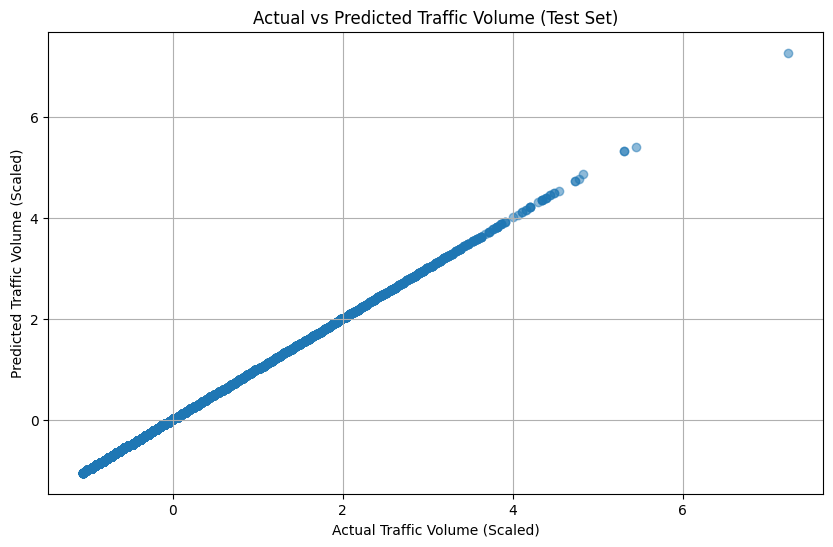

In [ ]:
# Plot actual vs predicted traffic volumes for the test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.xlabel("Actual Traffic Volume (Scaled)")
plt.ylabel("Predicted Traffic Volume (Scaled)")
plt.title("Actual vs Predicted Traffic Volume (Test Set)")
plt.grid(True)
plt.show()

**16. Summarize key findings and suggest how this prediction can help city planners. **

Based on the analysis:

*   **Key Findings:**
    *   Traffic volume exhibits strong daily and weekly seasonality, with predictable peaks during rush hours and lower volumes on weekends.
    *   Recent traffic volume ('Vehicles') is the most significant predictor of future traffic.
    *   The Random Forest model performed very well in predicting typical traffic patterns but may struggle with unpredictable outlier events.

*   **How Predictions Help City Planners:**
    *   **Proactive Congestion Management:** By predicting traffic volume for the next hour, planners can anticipate potential congestion hotspots before they occur.
    *   **Optimized Traffic Control:** Predictions can inform real-time adjustments to traffic light timings or the deployment of traffic control personnel to improve flow and reduce delays.
    *   **Resource Allocation:** Insights from predictions can help in planning and allocating resources effectively, such as emergency services or road maintenance crews, based on expected traffic conditions.
    *   **Informed Decision-Making:** The quantitative forecasts provide data-driven insights for making informed decisions about infrastructure improvements, traffic management strategies, and urban planning to alleviate future congestion.

In essence, the ability to predict traffic volume allows city planners to move from reactive traffic management to a more proactive and optimized approach, leading to smoother traffic flow and improved urban mobility.

## Section H: Advanced Challenge
---
**17. Implement a sequential model (GRU or LSTM) for traffic volume prediction. Compare performance with traditional regression models.**

### Data preparation for sequential models

**Subtask:**
Prepare the data in a sequential format suitable for GRU or LSTM, potentially creating sequences of past traffic volumes and relevant features to predict the next hour's traffic.


**Reasoning**:
Prepare the data for the sequential model by creating sequences and splitting into training and testing sets while preserving temporal order.



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, LSTM, Dropout

# 1. Define a function to create sequences
def create_sequences(data, lookback_window=1):
    X, y = [], []
    for i in range(len(data) - lookback_window):
        # Input sequence: features for the past 'lookback_window' hours
        seq_x = data[i:(i + lookback_window)][['Vehicles', 'Hour', 'DayofWeek', 'Weekend']].values
        # Target: 'Vehicles' value at the next hour
        seq_y = data.iloc[i + lookback_window]['Vehicles']
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# 2. Apply the function to create sequential data
lookback_window = 24 # Using a lookback window of 24 hours
X_seq, y_seq = create_sequences(df, lookback_window)

# 3. Reshape input sequences (already done by np.array) - verify shape
print("Shape of sequential X before reshaping:", X_seq.shape)
# The shape should be [samples, time steps, features] which is already the case with np.array

# 4. Split sequential data into training and testing sets while preserving temporal order
train_size = int(len(X_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:train_size], X_seq[train_size:]
y_train_seq, y_test_seq = y_seq[:train_size], y_seq[train_size:]

# Display the shapes of the resulting sequential sets
print("Shape of X_train_seq:", X_train_seq.shape)
print("Shape of X_test_seq:", X_test_seq.shape)
print("Shape of y_train_seq:", y_train_seq.shape)
print("Shape of y_test_seq:", y_test_seq.shape)

Shape of sequential X before reshaping: (48096, 24, 4)
Shape of X_train_seq: (38476, 24, 4)
Shape of X_test_seq: (9620, 24, 4)
Shape of y_train_seq: (38476,)
Shape of y_test_seq: (9620,)


**Reasoning**:
Train a GRU model using the prepared sequential data and evaluate its performance.



In [ ]:
# Define the GRU model
gru_model = Sequential()
gru_model.add(GRU(units=50, return_sequences=True, input_shape=(lookback_window, X_train_seq.shape[-1])))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(units=50))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(units=1))

# Compile the model
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
print("Training GRU model...")
history_gru = gru_model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, validation_split=0.2, verbose=1)
print("GRU model training finished.")

# Evaluate the GRU model
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred_gru = gru_model.predict(X_test_seq)

# Calculate RMSE and R-squared for GRU model
rmse_gru = np.sqrt(mean_squared_error(y_test_seq, y_pred_gru))
r2_gru = r2_score(y_test_seq, y_pred_gru)

# Print evaluation results
print("\nGRU Model Performance:")
print(f"  RMSE: {rmse_gru:.4f}")
print(f"  R-squared: {r2_gru:.4f}")

# Compare with previous models (Linear Regression and Random Forest)
print("\nComparison with Traditional Models:")
print("Linear Regression Model Performance:")
print(f"  RMSE: {rmse_lr:.4f}")
print(f"  R-squared: {r2_lr:.4f}")
print("\nRandom Forest Model Performance:")
print(f"  RMSE: {rmse_rf:.4f}")
print(f"  R-squared: {r2_rf:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training GRU model...
Epoch 1/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 34s 29ms/step - loss: 0.1181 - val_loss: 0.0750
Epoch 2/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - loss: 0.0487 - val_loss: 0.0727
Epoch 3/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 27s 28ms/step - loss: 0.0434 - val_loss: 0.0664
Epoch 4/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 27s 28ms/step - loss: 0.0438 - val_loss: 0.0685
Epoch 5/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - loss: 0.0403 - val_loss: 0.0658
Epoch 6/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - loss: 0.0386 - val_loss: 0.0686
Epoch 7/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - loss: 0.0372 - val_loss: 0.0689
Epoch 8/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - loss: 0.0366 - val_loss: 0.0709
Epoch 9/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 27s 28ms/step - loss: 0.0348 - val_loss: 0.0706
Epoch 10/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - loss: 0.0334 - val_loss: 0.0731
Epoch 11/20
962/962 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - loss: 0.0364 - val_loss: 0.0686
Epoch 12

# Section F: GitHub Repository

In [8]:
!git clone https://github.com/SaimaChowdhury/shestem-assignment__traffic.git

Cloning into 'shestem-assignment__traffic'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), 276.09 KiB | 1.89 MiB/s, done.


In [9]:
data= "/content/shestem-assignment__traffic/shestem_assignment__Traffic.ipynb"

The Github repository successfully cloned and loaded.😊